In [1]:
import sys
sys.path.append("../") 

In [2]:
import argparse, time, logging, random, math

import numpy as np
import mxnet as mx

from mxnet import gluon, nd
from mxnet import autograd as ag
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.,1.)
])

In [4]:
num_gpus = 1
model_ctx = mx.gpu()

num_workers = 4
batch_size = 256 
train_data = gluon.data.DataLoader(
    gluon.data.vision.MNIST(train=True).transform_first(transform),
    batch_size=batch_size, shuffle=True, last_batch='discard', num_workers=num_workers)

val_data = gluon.data.DataLoader(
    gluon.data.vision.MNIST(train=False).transform_first(transform),
    batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [5]:
for X,y in val_data:
    print(type(X))
    print(X.shape)
    print(y.shape)
    break

<class 'mxnet.ndarray.ndarray.NDArray'>
(256, 1, 28, 28)
(256,)


### Bayesian inference for MNIST

* [Stochastic Gradient Descent](#chapter1)
* [Stochastic Gradient Langevin Dynamics](#chapter2)
* [Bayes By Backprop](#chapter3)
* [Diagnostics](#chapter4)


# Stochastic Gradient Descent <a class="anchor" id="chapter1"></a>

In [6]:
import mxnet as mx
from mxnet import nd, autograd, gluon
hyper={'alpha':10.}
in_units=(28,28)
out_units=10

In [7]:
import mxnet as mx
from hamiltonian.inference.sgd import sgd
from hamiltonian.models.softmax import softmax

model=softmax(hyper,in_units,out_units,ctx=model_ctx)
inference=sgd(model,model.par,step_size=0.001,ctx=model_ctx)

In [8]:
import hamiltonian
import importlib

try:
    importlib.reload(hamiltonian.models.softmax)
    importlib.reload(hamiltonian.inference.sgd)
    print('modules re-loaded')
except:
    print('no modules loaded yet')


modules re-loaded


In [9]:
model.net.collect_params()

{'1.weight': Parameter (shape=(10, 784), dtype=float32),
 '1.bias': Parameter (shape=(10,), dtype=float32)}

In [10]:
import matplotlib.pyplot as plt 
import h5py 

train_sgd=False
num_epochs=10
if train_sgd:
    par,loss=inference.fit(epochs=num_epochs,batch_size=batch_size,
                           data_loader=train_data,chain_name='mnist_map.h5',verbose=True)

    fig=plt.figure(figsize=[5,5])
    plt.plot(loss,color='blue',lw=3)
    plt.xlabel('Epoch', size=18)
    plt.ylabel('Loss', size=18)
    plt.title('SGD Softmax MNIST', size=18)
    plt.xticks(size=14)
    plt.yticks(size=14)
    plt.savefig('sgd_softmax.pdf', bbox_inches='tight')
else:
    map_estimate=h5py.File('mnist_map.h5','r')
    par={var:map_estimate[var][:] for var in map_estimate.keys()}
    map_estimate.close()


In [12]:
from sklearn.metrics import classification_report

total_samples,total_labels,log_like=inference.predict(par,batch_size=batch_size,num_samples=100,data_loader=val_data)
y_hat=np.quantile(total_samples,.5,axis=0)
print(classification_report(np.int32(total_labels),np.int32(y_hat)))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       979
           1       0.97      0.93      0.95      1133
           2       0.88      0.84      0.86      1030
           3       0.83      0.86      0.84      1008
           4       0.85      0.88      0.86       980
           5       0.73      0.84      0.78       890
           6       0.84      0.92      0.88       956
           7       0.83      0.89      0.86      1027
           8       0.83      0.78      0.81       973
           9       0.94      0.76      0.84      1008

    accuracy                           0.86      9984
   macro avg       0.87      0.86      0.86      9984
weighted avg       0.87      0.86      0.86      9984



# Stochastic Gradient Langevin Dynamics <a class="anchor" id="chapter2"></a>

In [27]:
from hamiltonian.inference.sgld import sgld

model=softmax(hyper,in_units,out_units,ctx=model_ctx)
inference=sgld(model,model.par,step_size=0.001,ctx=model_ctx)

In [28]:
import hamiltonian
import importlib

try:
    importlib.reload(hamiltonian.models.softmax)
    importlib.reload(hamiltonian.inference.sgld)
    print('modules re-loaded')
except:
    print('no modules loaded yet')

modules re-loaded


 10%|█         | 1/10 [00:03<00:27,  3.08s/it]

loss: 1.1535


 20%|██        | 2/10 [00:06<00:24,  3.06s/it]

loss: 0.6811


 30%|███       | 3/10 [00:09<00:21,  3.06s/it]

loss: 0.5933


 40%|████      | 4/10 [00:12<00:18,  3.15s/it]

loss: 0.5439


 50%|█████     | 5/10 [00:15<00:16,  3.23s/it]

loss: 0.5198


 60%|██████    | 6/10 [00:19<00:13,  3.46s/it]

loss: 0.4959


 70%|███████   | 7/10 [00:22<00:10,  3.37s/it]

loss: 0.4826


 80%|████████  | 8/10 [00:27<00:07,  3.61s/it]

loss: 0.4715


 90%|█████████ | 9/10 [00:31<00:03,  3.80s/it]

loss: 0.4648


  0%|          | 0/10 [00:00<?, ?it/s]

loss: 0.4565


 10%|█         | 1/10 [00:03<00:30,  3.44s/it]

loss: 1.1874


 20%|██        | 2/10 [00:06<00:27,  3.44s/it]

loss: 0.6893


 30%|███       | 3/10 [00:10<00:23,  3.38s/it]

loss: 0.5933


 40%|████      | 4/10 [00:13<00:19,  3.32s/it]

loss: 0.5442


 50%|█████     | 5/10 [00:16<00:16,  3.27s/it]

loss: 0.5147


 60%|██████    | 6/10 [00:20<00:13,  3.39s/it]

loss: 0.4936


 70%|███████   | 7/10 [00:24<00:10,  3.52s/it]

loss: 0.4783


 80%|████████  | 8/10 [00:29<00:07,  4.00s/it]

loss: 0.4687


 90%|█████████ | 9/10 [00:34<00:04,  4.31s/it]

loss: 0.4598


100%|██████████| 10/10 [00:37<00:00,  3.75s/it]

loss: 0.4548


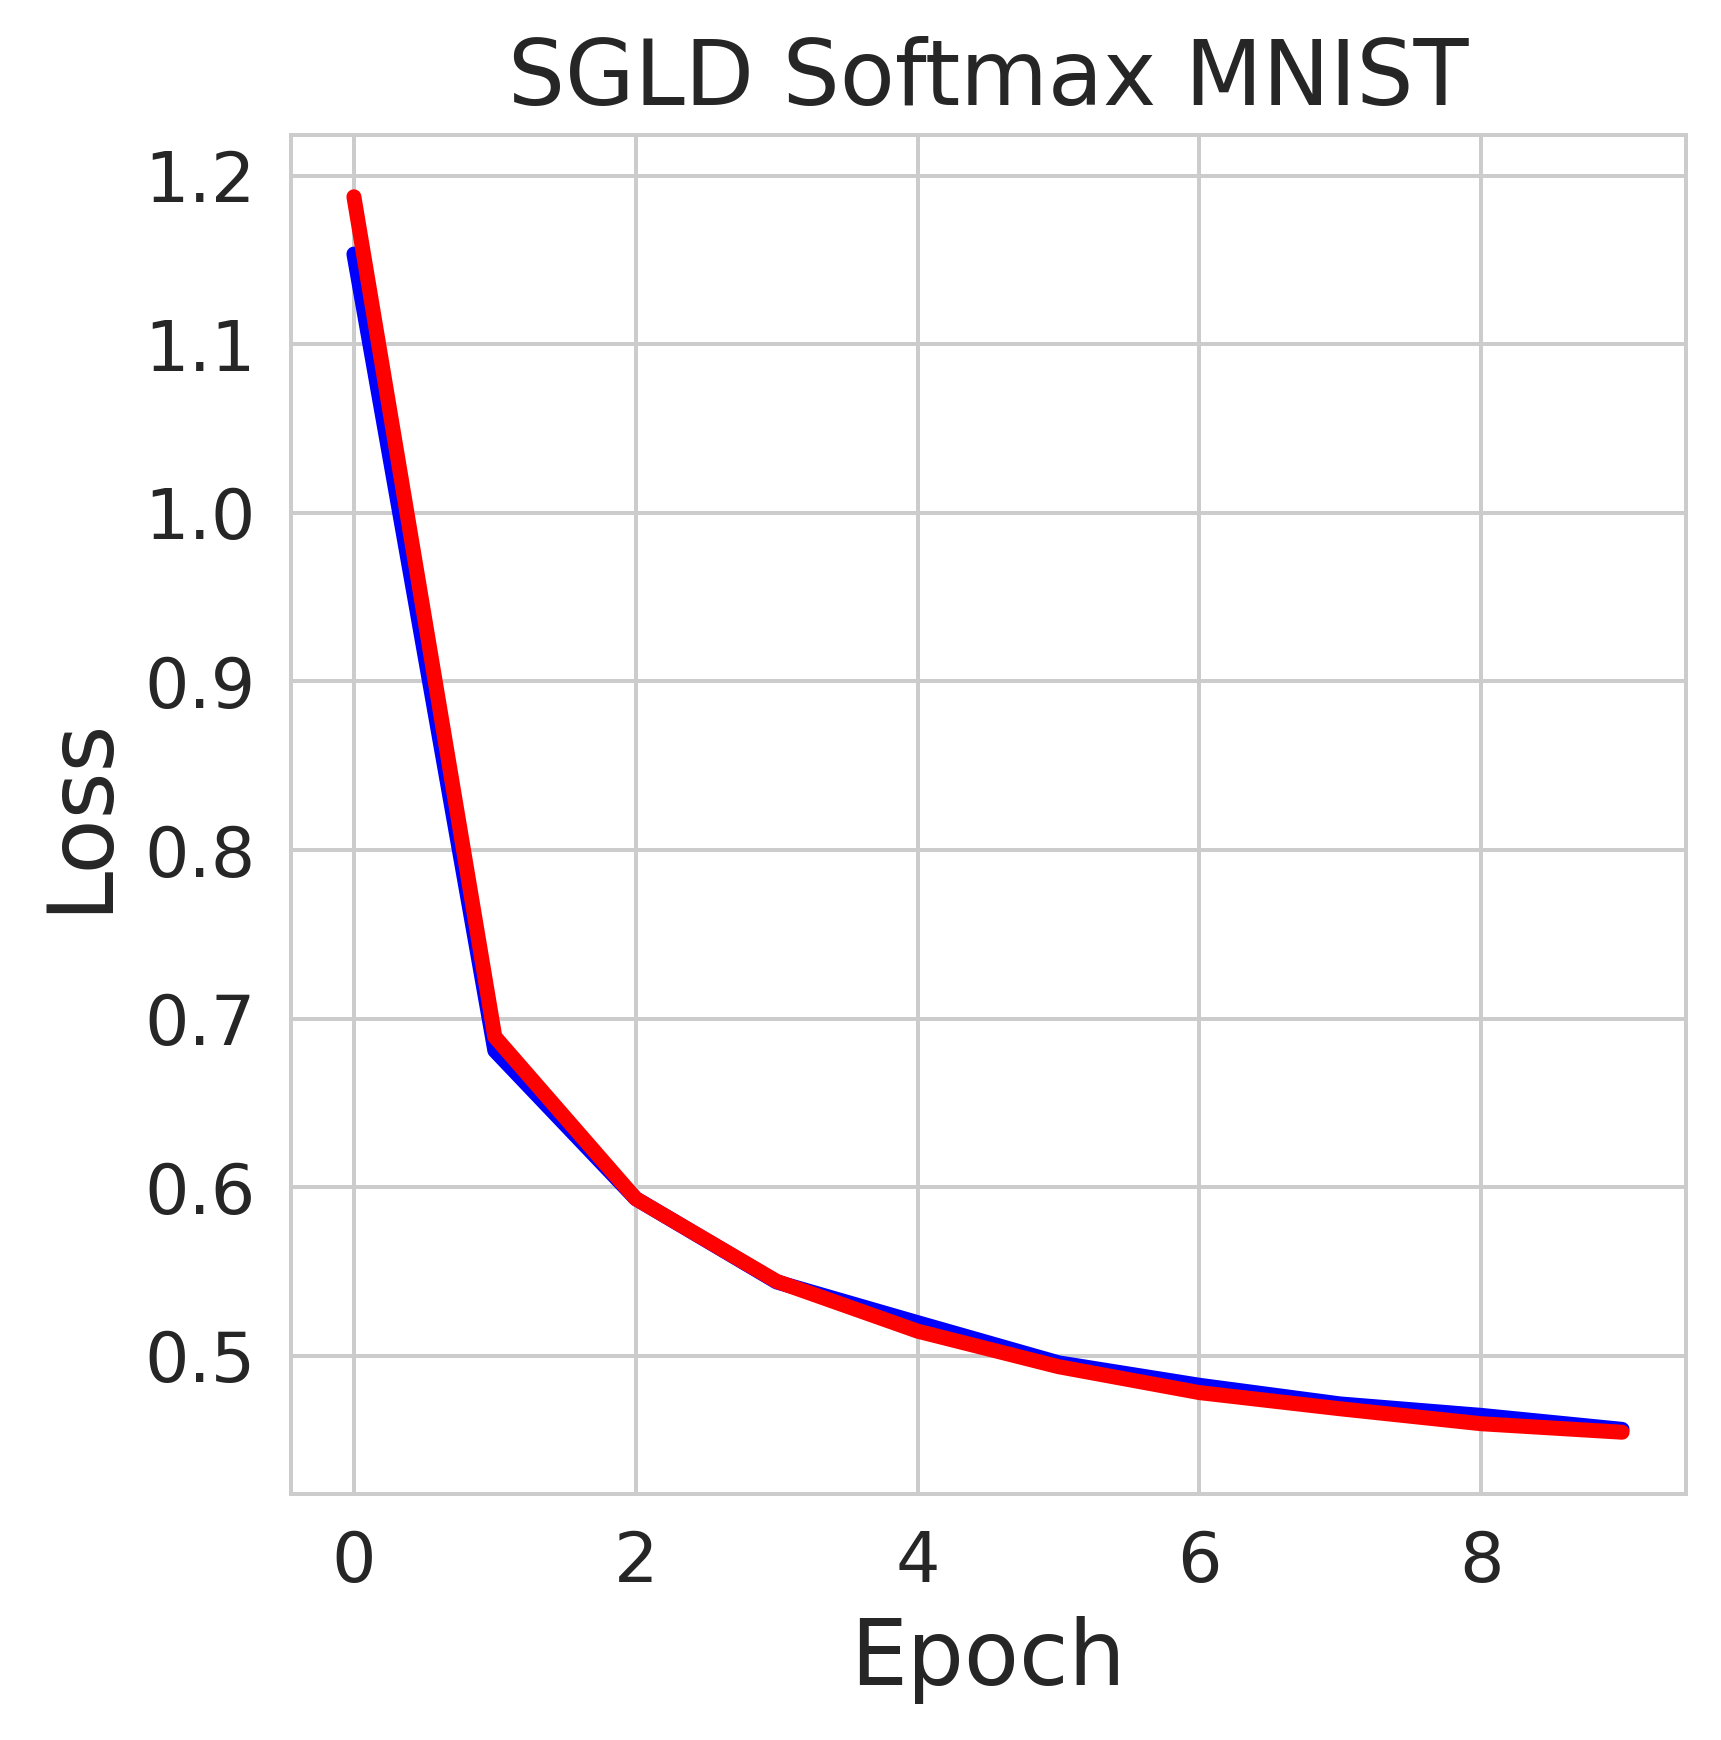

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import glob

train_sgld=True
num_epochs=10

if train_sgld:
    loss,posterior_samples=inference.sample(epochs=num_epochs,batch_size=batch_size,
                                data_loader=train_data,
                                verbose=True,chain_name='mnist_nonhierarchical.h5')

    plt.rcParams['figure.dpi'] = 360
    sns.set_style("whitegrid")
    fig=plt.figure(figsize=[5,5])
    plt.plot(loss[0],color='blue',lw=3)
    plt.plot(loss[1],color='red',lw=3)
    plt.xlabel('Epoch', size=18)
    plt.ylabel('Loss', size=18)
    plt.title('SGLD Softmax MNIST', size=18)
    plt.xticks(size=14)
    plt.yticks(size=14)
    plt.savefig('sgld_softmax.pdf', bbox_inches='tight')

In [40]:
import h5py 

posterior_samples=h5py.File('mnist_nonhierarchical.h5','r')

In [31]:
posterior_samples.attrs.keys()

<KeysViewHDF5 ['num_chains', 'num_samples']>

In [34]:
total_samples,total_labels,log_like=inference.predict(posterior_samples,data_loader=val_data)

In [46]:
posterior_samples.close()

In [36]:
y_hat=np.quantile(total_samples,0.7,axis=0)

In [37]:
y_hat.shape

(10000,)

In [38]:
from sklearn.metrics import f1_score

y_hat=np.quantile(total_samples,.1,axis=0)
score=f1_score(np.int32(total_labels),np.mean(total_samples,axis=0).astype(np.int32), average='macro')
print(score)
#print('mean f-1 : {0}, std f-1 : {1}'.format(np.mean(score),2*np.std(score)))

0.48458357036915867


In [41]:
import tensorflow as tf
import tensorflow_probability as tfp

samples={var:posterior_samples[var] for var in posterior_samples.keys()}
samples={var:np.swapaxes(samples[var],0,1) for var in model.par}
r_hat_estimate = lambda samples : tfp.mcmc.diagnostic.potential_scale_reduction(samples, independent_chain_ndims=1,split_chains=True).numpy()
rhat = {var:np.median(r_hat_estimate(samples[var])) for var in model.par}

In [42]:
rhat

{'1.weight': 6.3208637, '1.bias': 7.719115}

In [44]:
ess_estimate = lambda samples : tfp.mcmc.diagnostic.effective_sample_size(samples, filter_beyond_positive_pairs=True,cross_chain_dims=1).numpy()
ess = {var:np.median(ess_estimate(samples[var])) for var in model.par}

In [45]:
ess

{'1.weight': 2.9063973, '1.bias': 2.8665469}

In [ ]:
import dask.array as da 

df=h5py.File('mnist_nonhierarchical.h5','r')
samples={var:da.from_array(df[var]) for var in df.keys()}
r_hat_estimate={var:potential_scale_reduction(samples[var]) for var in samples.keys()}
ess_estimate={var:effective_sample_size(samples[var]) for var in samples.keys()}

In [271]:
ess = {var:np.median(ess_estimate[var]) for var in model.par}
rhat = {var:np.median(r_hat_estimate[var])  for var in model.par}

In [272]:
ess

{'1.weight': 1.6918622967224088, '1.bias': 6.755600823881087}

In [29]:
rhat

{'1.weight': 1.6774608, '1.bias': 1.106829}

In [30]:
import arviz as az

posterior_samples_multiple_chains=inference.posterior_diagnostics(posterior_samples)
datasets=[az.convert_to_inference_data(sample) for sample in posterior_samples_multiple_chains]
dataset = az.concat(datasets, dim="chain")

In [31]:
mean_r_hat_values={var:float(az.rhat(dataset)[var].median().data) for var in model.par}
mean_ess_values={var:float(az.ess(dataset)[var].median().data) for var in model.par}
mean_mcse_values={var:float(az.mcse(dataset)[var].median().data) for var in model.par}

In [32]:
print(mean_r_hat_values)

{'1.weight': 1.6655441421861479, '1.bias': 1.2943451036823195}


In [33]:
mean_ess_values

{'1.weight': 3.5239685309484114, '1.bias': 5.9626626923120085}

In [ ]:
mean_mcse_values

In [ ]:
from hamiltonian.utils.psis import *

loo,loos,ks=psisloo(log_like)

In [ ]:
max_ks=5

In [ ]:
ks[np.isinf(ks)]=max_ks

In [ ]:
plt.hist(ks)

In [ ]:
score=[]
for q in np.arange(.1,.9,.1):
    y_hat=np.quantile(total_samples,q,axis=0)
    score.append(f1_score(np.int32(total_labels),np.int32(y_hat), sample_weight=1-np.clip(ks,0,1),average='weighted'))
print('mean f-1 : {0}, std f-1 : {1}'.format(np.mean(score),2*np.std(score)))

In [ ]:
plt.rcParams['figure.dpi'] = 360
sns.set_style("whitegrid")
fig=plt.figure(figsize=[5,5])
plt.scatter(list(range(len(ks))),ks)
plt.plot(list(range(len(ks))), 0.7*(np.ones(len(ks))), linestyle='-',color='red')  # solid
plt.xlabel('Data point', size=18)
plt.ylabel('Pareto shape k', size=18)
plt.title('Non-hierarchical model', size=18)
plt.savefig('psis_sgld_softmax.pdf', bbox_inches='tight')

In [ ]:
np.sum(ks>1)

In [ ]:
ks[np.logical_and(ks>0.7,ks<1)].sum()

In [ ]:
ks[np.logical_and(ks>0.5,ks<0.7)].sum()

In [ ]:
np.sum(ks<0.5)

# Hierarchical Softmax <a class="anchor" id="chapter3"></a>

In [34]:
from hamiltonian.models.softmax import hierarchical_softmax
from hamiltonian.inference.sgld import sgld

model=hierarchical_softmax(hyper,in_units,out_units,ctx=model_ctx)
inference=sgld(model,model.par,step_size=0.001,ctx=model_ctx)

In [52]:
train_sgld=False
num_epochs=100

if train_sgld:
    loss,posterior_samples=inference.sample(epochs=num_epochs,batch_size=batch_size,
                                data_loader=train_data,
                                verbose=True,chain_name='mnist_hierarchical.h5')

    plt.rcParams['figure.dpi'] = 360
    sns.set_style("whitegrid")
    fig=plt.figure(figsize=[5,5])
    plt.plot(loss[0],color='blue',lw=3)
    plt.plot(loss[1],color='red',lw=3)
    plt.xlabel('Epoch', size=18)
    plt.ylabel('Loss', size=18)
    plt.title('SGLD Hierarchical Softmax MNIST', size=18)
    plt.xticks(size=14)
    plt.yticks(size=14)
    plt.savefig('sgld_hierarchical_softmax.pdf', bbox_inches='tight')


In [36]:
posterior_samples_flat=[item for sublist in posterior_samples for item in sublist]

In [37]:
total_samples,total_labels,log_like=inference.predict(posterior_samples_flat,5,data_loader=val_data)

In [38]:
from sklearn.metrics import f1_score

score=[]
for q in np.arange(.35,.75,.1):
    y_hat=np.quantile(total_samples,q,axis=0)
    score.append(f1_score(np.int32(total_labels),np.int32(y_hat), average='micro'))
print('mean f-1 : {0}, std f-1 : {1}'.format(np.mean(score),2*np.std(score)))

mean f-1 : 0.91585, std f-1 : 0.006073713855624048


In [39]:
import tensorflow as tf
import tensorflow_probability as tfp

posterior_samples_multiple_chains=inference.posterior_diagnostics(posterior_samples)
samples={var:np.concatenate([posterior_samples_multiple_chains[i][var] 
                        for i in range(len(posterior_samples_multiple_chains))]) 
                        for var in model.par}
samples={var:np.swapaxes(samples[var],0,1) for var in model.par}
r_hat_estimate = lambda samples : tfp.mcmc.diagnostic.potential_scale_reduction(samples, independent_chain_ndims=1,split_chains=True).numpy()
rhat = {var:np.median(r_hat_estimate(samples[var])) for var in model.par}

In [40]:
rhat

{'1.weight': 3.7939584, '1.bias': 1.1021233}

In [41]:
ess_estimate = lambda samples : tfp.mcmc.diagnostic.effective_sample_size(samples, filter_beyond_positive_pairs=True,cross_chain_dims=1).numpy()
ess = {var:np.median(ess_estimate(samples[var])) for var in model.par}

In [45]:
ess

{'1.weight': 3.1676974, '1.bias': 52.368546}

In [268]:
!rm posterior_samples.h5

In [250]:
importlib.reload(hamiltonian.utils.diagnostics)

<module 'hamiltonian.utils.diagnostics' from '/home/sergio/code/mxprob/benchmarks/../hamiltonian/utils/diagnostics.py'>

In [251]:
from hamiltonian.utils.diagnostics import *

posterior_samples_multiple_chains=inference.posterior_diagnostics(posterior_samples,serialize=True)

In [252]:
import dask.array as da 

df=h5py.File('posterior_samples.h5','r')
samples={var:da.from_array(df[var]) for var in df.keys()}
r_hat_estimate={var:potential_scale_reduction(samples[var]) for var in samples.keys()}
ess_estimate={var:effective_sample_size(samples[var]) for var in samples.keys()}

In [253]:
ess = {var:np.median(ess_estimate[var]) for var in model.par}
rhat = {var:np.median(r_hat_estimate[var])  for var in model.par}

In [254]:
ess

{'1.weight': 1.7391584476858615, '1.bias': 34.996306436053935}

In [255]:
rhat

{'1.weight': 1.6387938, '1.bias': 1.0146148}

In [256]:
import arviz as az

posterior_samples_multiple_chains=inference.posterior_diagnostics(posterior_samples)
datasets=[az.convert_to_inference_data(sample) for sample in posterior_samples_multiple_chains]
dataset = az.concat(datasets, dim="chain")
mean_r_hat_values={var:float(az.rhat(dataset)[var].mean().data) for var in model.par}
mean_ess_values={var:float(az.ess(dataset)[var].mean().data) for var in model.par}
mean_mcse_values={var:float(az.mcse(dataset)[var].mean().data) for var in model.par}

In [248]:
az.summary(dataset)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"1.weight[0,0]",-0.435,0.559,-1.392,0.534,0.233,0.174,6.0,54.0,1.28
"1.weight[0,1]",-0.538,0.454,-1.575,0.331,0.169,0.125,7.0,12.0,1.27
"1.weight[0,2]",-0.024,1.951,-2.739,2.450,1.267,1.037,3.0,12.0,1.89
"1.weight[0,3]",-0.790,0.887,-2.373,0.713,0.447,0.343,4.0,12.0,1.51
"1.weight[0,4]",-0.142,0.515,-0.970,0.821,0.230,0.173,5.0,21.0,1.35
...,...,...,...,...,...,...,...,...,...
1.bias[5],0.733,0.204,0.352,1.079,0.037,0.026,29.0,106.0,1.05
1.bias[6],-0.097,0.168,-0.413,0.209,0.025,0.021,47.0,104.0,1.04
1.bias[7],0.222,0.191,-0.121,0.554,0.020,0.014,87.0,75.0,1.06
1.bias[8],-0.577,0.197,-0.903,-0.223,0.031,0.022,39.0,131.0,1.08


In [67]:
print(mean_r_hat_values)

{'1.weight': 1.6711408591815198, '1.bias': 1.0529862404615036}


In [68]:
print(mean_ess_values)

{'1.weight': 4.9645475053530435, '1.bias': 57.65651747515627}


In [ ]:
print(mean_mcse_values)

In [ ]:
loo,loos,ks=psisloo(log_like)

In [ ]:
score=[]
for q in np.arange(.1,.9,.1):
    y_hat=np.quantile(total_samples,q,axis=0)
    score.append(f1_score(np.int32(total_labels[ks>0.7]),np.int32(y_hat[ks>0.7]), average='macro'))
print('mean f-1 : {0}, std f-1 : {1}'.format(np.mean(score),2*np.std(score)))

In [ ]:
score=[]
for q in np.arange(.1,.9,.1):
    y_hat=np.quantile(total_samples,q,axis=0)
    score.append(f1_score(np.int32(total_labels[ks<0.7]),np.int32(y_hat[ks<0.7]), average='macro'))
print('mean f-1 : {0}, std f-1 : {1}'.format(np.mean(score),2*np.std(score)))

In [ ]:
score=[]
for q in np.arange(.1,.9,.1):
    y_hat=np.quantile(total_samples,q,axis=0)
    score.append(f1_score(np.int32(total_labels),np.int32(y_hat), sample_weight=1-np.clip(ks,0,1),average='weighted'))
print('mean f-1 : {0}, std f-1 : {1}'.format(np.mean(score),2*np.std(score)))

In [ ]:
plt.rcParams['figure.dpi'] = 360
sns.set_style("whitegrid")
fig=plt.figure(figsize=[5,5])
plt.scatter(list(range(len(ks))),ks)
plt.plot(list(range(len(ks))), 0.7*(np.ones(len(ks))), linestyle='-',color='red')  # solid
plt.xlabel('Data point', size=18)
plt.ylabel('Pareto shape k', size=18)
plt.title('Hierarchical model', size=18)
plt.savefig('psis_sgld_hierarchical_softmax.pdf', bbox_inches='tight')

In [ ]:
np.sum(ks>1)

In [ ]:
ks[np.logical_and(ks>0.7,ks<1)].sum()

In [ ]:
ks[np.logical_and(ks>0.5,ks<0.7)].sum()

In [ ]:
np.sum(ks<0.5)